# Actividades 4-nov:
- Hub de mayor tamaño.
- Identificar comunidades y plotearlas de diferente color.

# Actividades 7-nov:
- Dado el ejercicio anterior, crear el mapa de calor utilizando el valor de threshold para mostrar la matriz binarizada.
- Hacer que ambas gráficas del grafo 3D y el mapa de calor se vean juntos.

In [1]:
# IMPORTAR LIBRERÍAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.signal import coherence
import mne
import community.community_louvain as community_louvain

# CARGAR ARCHIVO EDF
raw = mne.io.read_raw_edf(
    r"C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf",
    preload=True
)

# AJUSTAR FRECUENCIA DE MUESTREO Y FILTRAR
sfreq_target = 256  # frecuencia deseada
raw.resample(sfreq_target)  # resamplear si es necesario
raw.filter(1., 45., fir_design='firwin')  # filtro pasa banda 1–45 Hz

# EXTRAER MATRIZ DE DATOS Y NOMBRES DE CANALES
data = raw.get_data()  # matriz EEG (canales x tiempo)
ch_names = raw.info['ch_names']  # nombres de canales
n_channels = len(ch_names)  # número de canales

# CARGAR COORDENADAS 3D DE LOS ELECTRODOS
coordenadas_df = pd.read_csv(
    r"C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S03_datasets\EEG_practica\coordenadas_bipolares_eeg.csv"
)
coordenadas_df.set_index("canal", inplace=True)  # usar canal como índice

# CREAR DICCIONARIO DE POSICIONES 3D
pos3D = {
    canal: (
        coordenadas_df.loc[canal, "x"],
        coordenadas_df.loc[canal, "y"],
        coordenadas_df.loc[canal, "z"]
    )
    for canal in coordenadas_df.index
}

# CALCULAR MATRIZ DE COHERENCIA ESPECTRAL
fmin, fmax = 8, 13  # banda alfa
coh_matrix = np.zeros((n_channels, n_channels))  # inicializar matriz

for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(data[i], data[j], fs=sfreq_target, nperseg=sfreq_target)
        mask = (f >= fmin) & (f <= fmax)  # seleccionar banda alfa
        coh_matrix[i, j] = np.mean(Cxy[mask])  # promedio en banda

# CREAR DATAFRAME Y QUITAR DIAGONAL
eeg_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
np.fill_diagonal(eeg_df.values, 0)  # eliminar autocoherencia

# CREAR GRAFO Y DETECTAR COMUNIDADES
G = nx.from_numpy_array(np.abs(eeg_df.values))  # grafo no dirigido
partition = community_louvain.best_partition(G)  # detectar comunidades

# DETECTAR HUBS (GRADO MAYOR AL PROMEDIO)
degrees = dict(G.degree())  # grados de cada nodo
avg_degree = np.mean(list(degrees.values()))  # grado promedio
hubs = [node for node, deg in degrees.items() if deg > avg_degree]  # nodos hub

Extracting EDF parameters from C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\apgso\AppData\Local\Temp\ipykernel_2524\3157711480.py:12: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



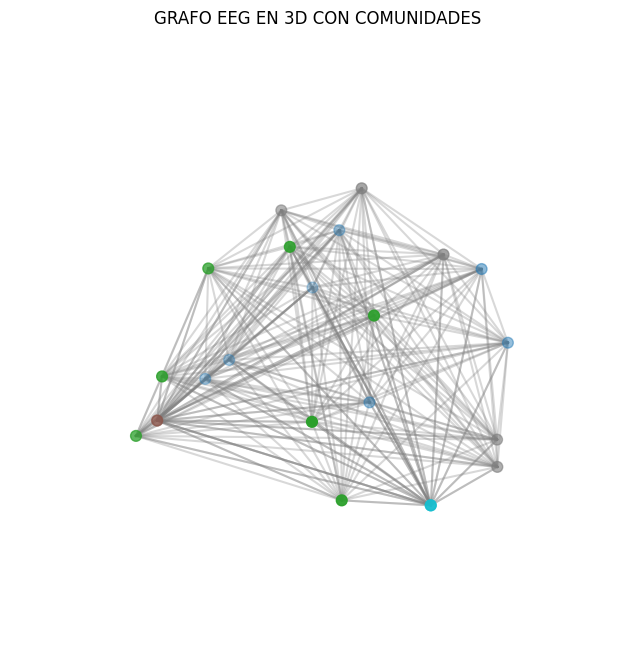

In [4]:
# GRAFICAR GRAFO 3D CON COMUNIDADES
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# EXTRAER POSICIONES X, Y, Z
xs = [pos3D[ch_names[i]][0] for i in range(n_channels)]
ys = [pos3D[ch_names[i]][1] for i in range(n_channels)]
zs = [pos3D[ch_names[i]][2] for i in range(n_channels)]
# COLORES POR COMUNIDAD
colors = [partition[i] for i in range(n_channels)]
# GRAFICAR NODOS
ax.scatter(xs, ys, zs, c=colors, cmap='tab10', s=60)
# GRAFICAR ARISTAS
for i, j in G.edges():
    x = [pos3D[ch_names[i]][0], pos3D[ch_names[j]][0]]
    y = [pos3D[ch_names[i]][1], pos3D[ch_names[j]][1]]
    z = [pos3D[ch_names[i]][2], pos3D[ch_names[j]][2]]
    ax.plot(x, y, z, color='gray', alpha=0.3)
# TÍTULO Y ESTILO
ax.set_title("GRAFO EEG EN 3D CON COMUNIDADES")
ax.axis("off")
plt.show()

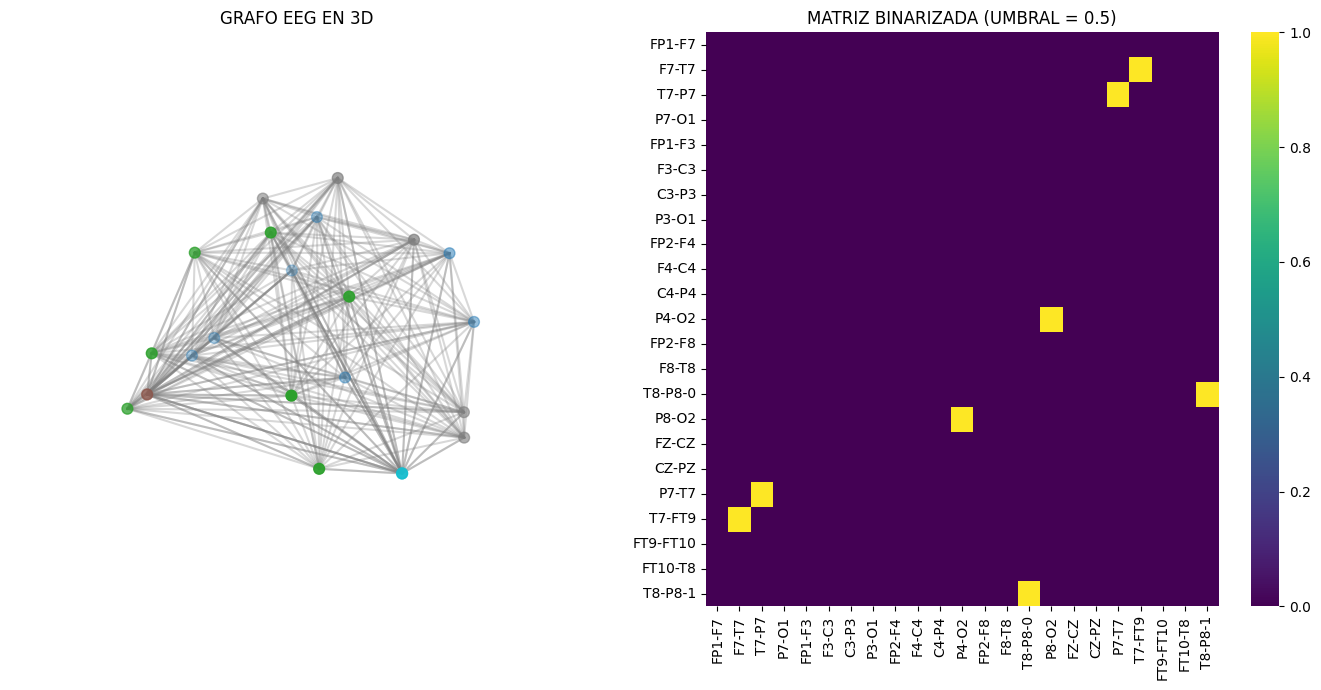

In [5]:
from mpl_toolkits.mplot3d import Axes3D  # para grafo 3D

# BINARIZAR MATRIZ DE COHERENCIA CON UMBRAL
threshold = 0.5  # umbral de conexión
binary_matrix = (eeg_df.values > threshold).astype(int)  # matriz binaria
# CREAR FIGURA CON DOS SUBPLOTS
fig = plt.figure(figsize=(14, 7))
# SUBPLOT 1: GRAFO EN 3D
ax1 = fig.add_subplot(121, projection='3d')  # primer eje en 3D
# POSICIONES Y COLORES
xs = [pos3D[ch_names[i]][0] for i in range(n_channels)]
ys = [pos3D[ch_names[i]][1] for i in range(n_channels)]
zs = [pos3D[ch_names[i]][2] for i in range(n_channels)]
colors = [partition[i] for i in range(n_channels)]
# NODOS
ax1.scatter(xs, ys, zs, c=colors, cmap='tab10', s=60)
# ARISTAS
for i, j in G.edges():
    x = [pos3D[ch_names[i]][0], pos3D[ch_names[j]][0]]
    y = [pos3D[ch_names[i]][1], pos3D[ch_names[j]][1]]
    z = [pos3D[ch_names[i]][2], pos3D[ch_names[j]][2]]
    ax1.plot(x, y, z, color='gray', alpha=0.3)
# TÍTULO Y ESTILO
ax1.set_title("GRAFO EEG EN 3D")
ax1.axis("off")
# SUBPLOT 2: MAPA DE CALOR BINARIZADO
ax2 = fig.add_subplot(122)  # segundo eje en 2D
sns.heatmap(binary_matrix, xticklabels=ch_names, yticklabels=ch_names, cmap="viridis", ax=ax2)
ax2.set_title("MATRIZ BINARIZADA (UMBRAL = 0.5)")
# AJUSTAR DISEÑO
plt.tight_layout()
plt.show()